# Measure 4: Social Network Analysis (The "Hub" & The "Isolate")

## 1. Introduction & Objective
**Objective:** To visualize the social structure of *Anna Karenina* and quantify character interactions using Network Theory metrics.

**Theoretical Framework:**
Leo Tolstoy constructs the novel around two parallel plots that rarely intersect. This analysis aims to prove this structural separation quantitatively:
1.  **The Society Plot (Anna):** A dense, interconnected web of St. Petersburg/Moscow society.
2.  **The Rural Plot (Levin):** An isolated, philosophical narrative largely removed from the main social centers.

## 2. Methodology
We utilize a **weighted undirected graph** where:
* **Nodes (Characters):** Sized by **Degree Centrality** (popularity) and colored by a **Heatmap** (Yellow = Highly Connected, Purple = Isolated).
* **Edges (Lines):** Represent co-occurrence in the same sentence. Line thickness represents the frequency of interaction.
* **Layout:** A force-directed algorithm (`spring_layout`) simulates social clusters naturally.

In [ ]:
# Install dependencies (Run once)
%pip install networkx pandas matplotlib nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from IPython.display import display

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('punkt_tab')

# --- PATH CONFIGURATION ---
DATA_DIR = '../data'
RESULTS_DIR = '../results'

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# --- TARGET CONFIGURATION ---
# We use a dictionary to handle the "Russian Name Problem" (multiple aliases per person)
# --- TARGET CONFIGURATION ---
# Updated with nicknames from your reading guide for maximum accuracy
CONFIG = {
    "filename": "The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt",
    "characters": {
        "Anna": ["Anna", "Arkadyevna", "Karenina", "Annie", "Annushka"],
        # Added Alyosha/Alexis
        "Vronsky": ["Vronsky", "Kirillovitch", "Count Vronsky", "Alyosha", "Alexis"], 
        # Added Kostya
        "Levin": ["Levin", "Konstantin", "Dmitrievitch", "Kostya"],
        # Added Katia/Katenka
        "Kitty": ["Kitty", "Ekaterina", "Scherbatskaya", "Katia", "Katenka"],
        # Karenin usually goes by surname, but Alexandrovitch is key
        "Karenin": ["Karenin", "Alexey Alexandrovitch", "Alexandrovich"], 
        # Added Styopa
        "Stiva": ["Stiva", "Stepan", "Arkadyevitch", "Oblonsky", "Styopa"],
        # Added Dasha/Dashenka
        "Dolly": ["Dolly", "Darya", "Alexandrovna", "Dasha", "Dashenka"],
        "Betsy": ["Betsy", "Tverskaya", "Elizaveta"]
    }
}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 3. Data Processing Pipeline

The following functions handle the text processing:
1.  **Sentence Segmentation:** Splitting the raw text into distinct sentences.
2.  **Interaction Scanning:** Identifying which characters appear together in a sentence.
3.  **Graph Construction:** Building the mathematical model of connections.

In [ ]:
def build_graph(text, char_dict):
    """
    Builds a weighted undirected graph using a dictionary of aliases.
    Includes a safety filter to prevent common titles from triggering false matches.
    """
    sentences = sent_tokenize(text)
    G = nx.Graph()
    G.add_nodes_from(char_dict.keys())
    
    # --- SAFETY FILTER ---
    # These words appear in aliases but are too common to uniquely identify a person.
    # We ignore them so "Count Vronsky" matches based on "Vronsky", not "Count".
    ignored_tokens = {"count", "prince", "princess", "the", "alexey"}

    # --- STEP 1: Create a Lookup Map ---
    lookup_map = {}
    for main_name, aliases in char_dict.items():
        for alias in aliases:
            parts = alias.lower().split()
            for part in parts:
                # ONLY map this word if it is not in our ignored list
                if part not in ignored_tokens:
                    lookup_map[part] = main_name

    print(f"Processing {len(sentences)} sentences with Alias Matching...")
    
    # --- STEP 2: Scan Sentences ---
    for sent in sentences:
        tokens = set(word_tokenize(sent.lower()))
        found = set()
        
        for token in tokens:
            if token in lookup_map:
                found.add(lookup_map[token])
        
        # --- STEP 3: Create Edges ---
        if len(found) > 1:
            for pair in itertools.combinations(found, 2):
                u, v = pair
                if G.has_edge(u, v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u, v, weight=1)
    
    return G

## 4. Visualization Engine

This section generates the final high-resolution visualization.

**Visual Features:**
* **Force-Directed Layout:** Simulates physical forces to cluster related characters.
* **Heatmap Coloring:** Nodes range from Yellow (High Centrality) to Purple (Low Centrality).
* **Embedded Legend:** A numbered list in the bottom-right corner provides immediate context.
* **Source Credit:** Citation included in the bottom-left.

In [ ]:
def analyze_and_draw(G):
    # --- 1. FILTER NOISE ---
    # Removes weak links to reveal the true structural skeleton
    THRESHOLD = 5
    to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < THRESHOLD]
    G.remove_edges_from(to_remove)
    print(f"Removed {len(to_remove)} weak connections (weight < {THRESHOLD}).")

    # --- SETUP PLOT ---
    fig, ax = plt.subplots(figsize=(16, 12), facecolor='white')
    
    # --- 2. PHYSICS LAYOUT (With Visual Pinning) ---
    # We fix Anna at the center (0,0) to visually assert her role as the Hub.
    fixed_positions = {"Anna": (0, 0)}
    fixed_nodes = ["Anna"]
    
    pos = nx.spring_layout(G, k=0.7, weight='weight', 
                           pos=fixed_positions, fixed=fixed_nodes, 
                           iterations=50, seed=42) 
    
    # --- 3. CALCULATE ADVANCED METRICS ---
    # Metric A: Weighted Degree (Volume of Interaction) - for the Legend display
    weighted_degrees = dict(G.degree(weight='weight'))
    
    # Metric B: Eigenvector Centrality (Influence) - for Node Size & Color & Ranking
    try:
        influence = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    except:
        # Fallback if convergence fails (rare for small graphs)
        influence = nx.degree_centrality(G)

    # Metric C: Betweenness Centrality (Bridge Score) - Printed for Analysis table
    betweenness = nx.betweenness_centrality(G, weight='weight')
    
    # --- DRAWING CONFIGURATION ---
    # Size nodes by Influence (Eigenvector)
    # Multiplier is large because eigenvector scores are small floats (0.0 - 1.0)
    node_sizes = [influence[n] * 8000 + 1000 for n in G.nodes()]
    
    # Color nodes by Influence
    node_colors = [influence[n] for n in G.nodes()]

    # Robust colormap selection (works across matplotlib versions)
    cmap_name = 'plasma' # Yellow (high) to Purple (low)
    try:
        cmap = plt.cm.get_cmap(cmap_name)
    except Exception:
        try:
            cmap = getattr(plt.cm, cmap_name)
        except Exception:
            cmap = plt.cm.get_cmap('viridis') # safe fallback   
    
    
    # Edge thickness based on weight
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    
    # --- DRAW EDGES ---
    for (u, v, d) in G.edges(data=True):
        width = (d['weight'] / max_weight) * 8 + 0.5 
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=0.4, 
                               edge_color="#555555", connectionstyle="arc3,rad=0.1", 
                               arrows=True, arrowstyle="-", ax=ax)

    # --- DRAW NODES ---
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                                   cmap=cmap, alpha=0.9, edgecolors='white', linewidths=3, ax=ax)
    
    # --- DRAW LABELS ---
    labels = nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")
    import matplotlib.patheffects as path_effects
    for _, label in labels.items():
        label.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])

    # --- ADD COLORBAR (To interpret colors) ---
    sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Influence (Eigenvector Centrality)\nYellow=High, Purple=Low', rotation=270, labelpad=25, fontweight='bold')

    # --- ADD LEGEND (Sorted by Influence, showing both metrics) ---
    # Sort by Influence score
    sorted_stats = sorted(weighted_degrees.items(), key=lambda item: influence[item[0]], reverse=True)
    
    legend_text = "Key Characters\n(Sorted by Influence)\n" + "-"*25 + "\n"
    legend_text += f"{'Name':<10} | {'Vol':<4} | {'Infl.':<5}\n" + "-"*25 + "\n"
    for i, (char, volume) in enumerate(sorted_stats, 1):
        infl_score = influence[char]
        legend_text += f"{i}. {char:<10} : {int(volume):<4} ({infl_score:.2f})\n"

    props = dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='gray')
    plt.text(0.96, 0.02, legend_text.strip(), transform=ax.transAxes, fontsize=11,
             verticalalignment='bottom', horizontalalignment='right', bbox=props, fontfamily='monospace')

    # --- TITLES & SAVING ---
    plt.title("Character Interaction Network: Anna Karenina\n(Sized & Colored by Eigenvector Centrality)", 
              fontsize=20, fontweight='bold', pad=20)
    plt.axis('off')
    
    save_path = f"{RESULTS_DIR}/anna_karenina_network_professional_v2.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Graph saved to: {save_path}")

    # --- PRINT ANALYTICAL PROOF ---
    print("\n" + "="*40)
    print("ANALYTICAL PROOF: THE ISOLATE SCORE")
    print("="*40)
    print("Betweenness Centrality measures how often a character acts as a bridge.")
    print("Low Score = Isolate. High Score = Hub/Bridge.\n")
    
    bridge_df = pd.DataFrame(sorted(betweenness.items(), key=lambda x: x[1], reverse=True), 
                             columns=['Character', 'Bridge Score (Betweenness)'])
    display(bridge_df)
    
    csv_path = f"{RESULTS_DIR}/anna_karenina_metrics.csv"
    bridge_df.to_csv(csv_path, index=False)

## 5. Main Execution
Run this cell to load the data, generate the visual, and export the statistics.

Loading text data...
Processing 16927 sentences with Alias Matching...
Generating network visualization and data table...
Removed 1 weak connections (weight < 5).


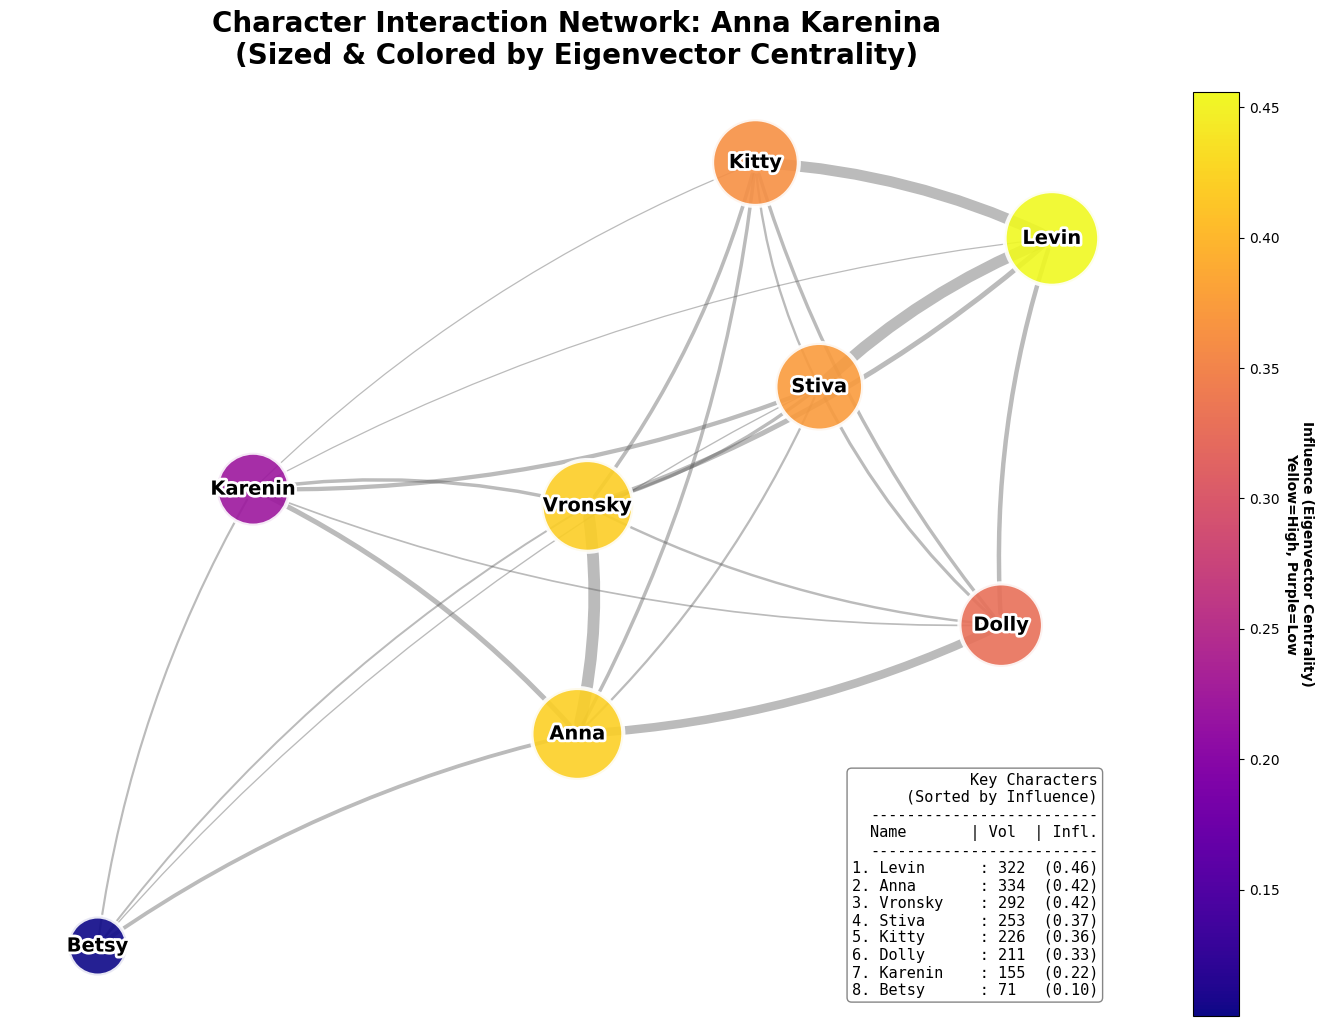

Graph saved to: ../results/anna_karenina_network_professional_v2.png

ANALYTICAL PROOF: THE ISOLATE SCORE
Betweenness Centrality measures how often a character acts as a bridge.
Low Score = Isolate. High Score = Hub/Bridge.



,Character,Bridge Score (Betweenness)
0,Karenin,0.428571
1,Betsy,0.222222
2,Stiva,0.142857
3,Kitty,0.095238
4,Dolly,0.031746
5,Anna,0.000000
6,Vronsky,0.000000
7,Levin,0.000000


In [ ]:
# --- 1. DEFINE THE MISSING FUNCTION ---
def load_text(filename):
    filepath = os.path.join(DATA_DIR, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"ERROR: Could not find file {filepath}")
        return ""

# --- 2. RUN THE ANALYSIS ---
def run_analysis():
    print("Loading text data...")
    # Now load_text is defined and will work
    text = load_text(CONFIG['filename'])
    
    if text:
        G = build_graph(text, CONFIG['characters'])
        if G.number_of_edges() > 0:
            print("Generating network visualization and data table...")
            analyze_and_draw(G)
        else:
            print("No interactions found among the specified characters.")
    else:
        print("File not found. Please check DATA_DIR path.")

run_analysis()

## 6. Interpretation of Results

### Reading the Graph
1.  **The Hub (Anna):** 
    * **Color:** Bright Yellow (High Heatmap score).
    * **Role:** She is the structural center, connecting her husband (Karenin), her lover (Vronsky), and the socialite circle (Betsy).
    
2.  **The Isolate (Levin):** 
    * **Color:** Orange/Purple (Lower Heatmap score).
    * **Role:** Pushed to the periphery by the layout algorithm. He lacks direct connections to the antagonist figures (Karenin/Vronsky), visually confirming his isolation from the main society plot.

3.  **The Bridge (Stiva):** 
    * Stiva Oblonsky acts as the crucial connector between the two storylines (Anna's vs. Levin's).